<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 5.77 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 18:15:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 7.8 MB/s 
     |████████████████████████████████| 133 kB 59.8 MB/s 
     |████████████████████████████████| 170 kB 38.7 MB/s 
     |████████████████████████████████| 97 kB 8.7 MB/s 
     |████████████████████████████████| 138 kB 58.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 9ii9dv7m
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/9ii9dv7m


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: bp1ys247 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
8/8 [==============================] - 37s 164ms/step - loss: 0.1938 - mean_squared_error: 0.1938 - mean_absolute_error: 0.3491 - val_loss: 0.0946 - val_mean_squared_error: 0.0946 - val_mean_absolute_error: 0.2707
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1791 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1500
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0779 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1528
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0557 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1564
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.003

epoch,99
loss,0.00157
mean_squared_error,0.00157
mean_absolute_error,0.03116
val_loss,0.01709
val_mean_squared_error,0.01709
val_mean_absolute_error,0.10287
_runtime,55
_timestamp,1626891438
_step,99
best_val_loss,0.01709


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1c4v4xaa with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 4s 33ms/step - loss: 3.6064 - mean_squared_error: 3.6064 - mean_absolute_error: 0.8948 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1421
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0788 - mean_squared_error: 0.0788 - mean_absolute_error: 0.2147 - val_loss: 0.0693 - val_mean_squared_error: 0.0693 - val_mean_absolute_error: 0.2262
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - mean_absolute_error: 0.1530 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1457
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - mean_absolute_error: 0.1013 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1355
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_squared_error: 0.

epoch,27
loss,0.00347
mean_squared_error,0.00347
mean_absolute_error,0.04515
val_loss,0.01864
val_mean_squared_error,0.01864
val_mean_absolute_error,0.10818
_runtime,13
_timestamp,1626891473
_step,27
best_val_loss,0.01768


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▃▃▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▃█▃▃▂▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▃█▃▃▃▃▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: umso856t with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 4s 32ms/step - loss: 0.1315 - mean_squared_error: 0.1315 - mean_absolute_error: 0.2993 - val_loss: 0.0474 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1881
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0891 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1757
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0757 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1725
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0681 - val_loss: 0.0420 - val_mean_squared_error: 0.0420 - val_mean_absolute_error: 0.1726
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0063 - mean_squared_erro

epoch,199
loss,0.00196
mean_squared_error,0.00196
mean_absolute_error,0.03458
val_loss,0.0233
val_mean_squared_error,0.0233
val_mean_absolute_error,0.1217
_runtime,54
_timestamp,1626891534
_step,199
best_val_loss,0.02318


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cfxiexxj with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 4s 63ms/step - loss: 0.0585 - mean_squared_error: 0.0585 - mean_absolute_error: 0.1901 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1566
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0608 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1591
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0504 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1545
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0487 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1525
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.

epoch,49
loss,0.00163
mean_squared_error,0.00163
mean_absolute_error,0.03153
val_loss,0.01776
val_mean_squared_error,0.01776
val_mean_absolute_error,0.10506
_runtime,14
_timestamp,1626891591
_step,49
best_val_loss,0.01776


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g2m0jugh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 3s 29ms/step - loss: 0.0671 - mean_squared_error: 0.0671 - mean_absolute_error: 0.1811 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1655
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0457 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1203
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0358 - val_loss: 0.0196 - val_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.1111
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0339 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.1044
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_erro

epoch,42
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.0243
val_loss,0.01154
val_mean_squared_error,0.01154
val_mean_absolute_error,0.08536
_runtime,16
_timestamp,1626891617
_step,42
best_val_loss,0.01066


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▂▁▂▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▁▁▁▂▁▂▁
val_mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▁▁▂▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 0cug4i09 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 123ms/step - loss: 3.6706 - mean_squared_error: 3.6706 - mean_absolute_error: 1.3951 - val_loss: 0.0695 - val_mean_squared_error: 0.0695 - val_mean_absolute_error: 0.2221
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1676 - mean_squared_error: 0.1676 - mean_absolute_error: 0.3359 - val_loss: 0.0874 - val_mean_squared_error: 0.0874 - val_mean_absolute_error: 0.2404
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1096 - mean_squared_error: 0.1096 - mean_absolute_error: 0.2383 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.1917
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1313 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1740
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0097 - mean_squared_error: 0.009

epoch,86
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02553
val_loss,0.0099
val_mean_squared_error,0.0099
val_mean_absolute_error,0.07722
_runtime,17
_timestamp,1626891642
_step,86
best_val_loss,0.00971


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vzi2e4eu with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 4s 59ms/step - loss: 0.2627 - mean_squared_error: 0.2627 - mean_absolute_error: 0.4433 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1483
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0896 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1831
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0968 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1549
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0670 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1454
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0061 - mean_squared_erro

epoch,199
loss,0.00222
mean_squared_error,0.00222
mean_absolute_error,0.03764
val_loss,0.02069
val_mean_squared_error,0.02069
val_mean_absolute_error,0.11316
_runtime,40
_timestamp,1626891690
_step,199
best_val_loss,0.02069


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 98iqyof7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 117ms/step - loss: 0.3551 - mean_squared_error: 0.3551 - mean_absolute_error: 0.5286 - val_loss: 0.1733 - val_mean_squared_error: 0.1733 - val_mean_absolute_error: 0.3518
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1605 - mean_squared_error: 0.1605 - mean_absolute_error: 0.3355 - val_loss: 0.0561 - val_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.1863
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1550 - val_loss: 0.0384 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1651
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1064 - val_loss: 0.0478 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1889
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0180 - mean_squared_error: 0.0180

epoch,199
loss,0.00279
mean_squared_error,0.00279
mean_absolute_error,0.04181
val_loss,0.03136
val_mean_squared_error,0.03136
val_mean_absolute_error,0.14318
_runtime,29
_timestamp,1626891728
_step,199
best_val_loss,0.03136


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lkms7mvi with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 57ms/step - loss: 2.0350 - mean_squared_error: 2.0350 - mean_absolute_error: 1.0118 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - val_mean_absolute_error: 0.2101
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - mean_absolute_error: 0.1695 - val_loss: 0.0478 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1874
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0771 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1369
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0504 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1321
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.

epoch,49
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02485
val_loss,0.00949
val_mean_squared_error,0.00949
val_mean_absolute_error,0.07531
_runtime,16
_timestamp,1626891754
_step,49
best_val_loss,0.00949


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ggs4rgha with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 62ms/step - loss: 0.0919 - mean_squared_error: 0.0919 - mean_absolute_error: 0.2265 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1586
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0944 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1518
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0541 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1632
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0467 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1476
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_erro

epoch,53
loss,0.00095
mean_squared_error,0.00095
mean_absolute_error,0.02409
val_loss,0.01175
val_mean_squared_error,0.01175
val_mean_absolute_error,0.08546
_runtime,17
_timestamp,1626891781
_step,53
best_val_loss,0.01115


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▇▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▂▂▁▂▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 2qncg37g with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 58ms/step - loss: 0.2816 - mean_squared_error: 0.2816 - mean_absolute_error: 0.4607 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1636
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0943 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1896
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0993 - val_loss: 0.0381 - val_mean_squared_error: 0.0381 - val_mean_absolute_error: 0.1651
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0748 - val_loss: 0.0355 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1553
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.

epoch,49
loss,0.00336
mean_squared_error,0.00336
mean_absolute_error,0.0456
val_loss,0.03247
val_mean_squared_error,0.03247
val_mean_absolute_error,0.14292
_runtime,16
_timestamp,1626891815
_step,49
best_val_loss,0.03247


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▄▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▄▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ib02ipmo with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 126ms/step - loss: 3.8463 - mean_squared_error: 3.8463 - mean_absolute_error: 1.0747 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1597
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0493 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1601
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0480 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1671
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1487 - val_loss: 0.1078 - val_mean_squared_error: 0.1078 - val_mean_absolute_error: 0.2803
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - m

epoch,11
loss,0.01495
mean_squared_error,0.01495
mean_absolute_error,0.10486
val_loss,0.0422
val_mean_squared_error,0.0422
val_mean_absolute_error,0.17129
_runtime,9
_timestamp,1626891835
_step,11
best_val_loss,0.03792


epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▃▂▃▁▂▁▂▂▂
val_loss,▁▁▁█▂▁▃▁▄▁▂▁
val_mean_squared_error,▁▁▁█▂▁▃▁▄▁▂▁
val_mean_absolute_error,▁▁▁█▃▁▃▂▅▁▂▂
_runtime,▁▁▁█████████
_timestamp,▁▁▁█████████
_step,▁▂▂▃▄▄▅▅▆▇▇█


wandb: Agent Starting Run: oy3o6iru with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 4s 33ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - mean_absolute_error: 0.1128 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1595
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0635 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1261
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0596 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1159
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0603 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1194
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_erro

epoch,35
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.03088
val_loss,0.01421
val_mean_squared_error,0.01421
val_mean_absolute_error,0.09446
_runtime,18
_timestamp,1626891864
_step,35
best_val_loss,0.01227


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁
val_loss,█▅▄▄▃▂▂▃▂▂▆▂▃▂▂▃▂▁▁▂▃▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂
val_mean_squared_error,█▅▄▄▃▂▂▃▂▂▆▂▃▂▂▃▂▁▁▂▃▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂
val_mean_absolute_error,█▅▄▄▄▃▂▃▂▂▆▂▃▂▂▃▂▁▂▂▃▂▁▁▁▁▂▁▂▁▂▁▁▁▃▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: roejawsw with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 4s 175ms/step - loss: 0.2338 - mean_squared_error: 0.2338 - mean_absolute_error: 0.4133 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1700
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1287 - val_loss: 0.0838 - val_mean_squared_error: 0.0838 - val_mean_absolute_error: 0.2542
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1531 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1777
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0878 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1599
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0107 - mean_squared_error: 0.0107

epoch,13
loss,0.00358
mean_squared_error,0.00358
mean_absolute_error,0.04754
val_loss,0.04105
val_mean_squared_error,0.04105
val_mean_absolute_error,0.16605
_runtime,10
_timestamp,1626891883
_step,13
best_val_loss,0.03942


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁
val_loss,▁█▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁█▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂█▂▁▂▂▂▁▂▂▂▂▁▁
_runtime,▁▅▅▅▅▅▅▅▅▅▅▅██
_timestamp,▁▅▅▅▅▅▅▅▅▅▅▅██
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 22skkg8c with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 31ms/step - loss: 0.0944 - mean_squared_error: 0.0944 - mean_absolute_error: 0.2225 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1464
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0525 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1283
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0446 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1098
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0359 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1000
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_erro

epoch,45
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02494
val_loss,0.0102
val_mean_squared_error,0.0102
val_mean_absolute_error,0.07747
_runtime,20
_timestamp,1626891912
_step,45
best_val_loss,0.00925


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 0q0a1jlr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 4s 34ms/step - loss: 0.4955 - mean_squared_error: 0.4955 - mean_absolute_error: 0.3192 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1497
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.0811 - val_loss: 0.1112 - val_mean_squared_error: 0.1112 - val_mean_absolute_error: 0.2836
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1431 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1679
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0706 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1272
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0053 - mean_squared_erro

epoch,57
loss,0.00165
mean_squared_error,0.00165
mean_absolute_error,0.03182
val_loss,0.0098
val_mean_squared_error,0.0098
val_mean_absolute_error,0.07573
_runtime,22
_timestamp,1626891950
_step,57
best_val_loss,0.00896


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▄▃▂▃▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fnl45g5d with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 123ms/step - loss: 0.1642 - mean_squared_error: 0.1642 - mean_absolute_error: 0.3258 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1550
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.1012 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1384
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0565 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1401
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0505 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1801
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0330 - mean_squared_error: 0.

epoch,81
loss,0.0017
mean_squared_error,0.0017
mean_absolute_error,0.03194
val_loss,0.01045
val_mean_squared_error,0.01045
val_mean_absolute_error,0.07883
_runtime,19
_timestamp,1626891979
_step,81
best_val_loss,0.01025


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▅▂▁▃▁▁▂▁▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▇▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▇▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▆▆▅▄█▃▃▄▄▃▂▃▃▂▂▂▂▃▂▂▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: eusektr3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 4s 120ms/step - loss: 0.1543 - mean_squared_error: 0.1543 - mean_absolute_error: 0.2946 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1703
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0508 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1689
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0742 - val_loss: 0.0663 - val_mean_squared_error: 0.0663 - val_mean_absolute_error: 0.2198
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0916 - val_loss: 0.0501 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1895
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0179 - mean_squared_error: 0.017

epoch,52
loss,0.00213
mean_squared_error,0.00213
mean_absolute_error,0.03662
val_loss,0.02168
val_mean_squared_error,0.02168
val_mean_absolute_error,0.11709
_runtime,14
_timestamp,1626892004
_step,52
best_val_loss,0.01647


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▃▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▃▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▅▄▃▃▂▄▁▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▂▁▁
val_loss,▅▄█▄▇▃▄▃▄▃▃▅▄▂▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▂▁▁▁▂▂
val_mean_squared_error,▅▄█▄▇▃▄▃▄▃▃▅▄▂▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▂▁▁▁▂▂
val_mean_absolute_error,▅▅█▅▇▄▅▃▄▄▃▅▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▃▁▁▂▁▁▁▂▂
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gxe2fe7u with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 62ms/step - loss: 0.0810 - mean_squared_error: 0.0810 - mean_absolute_error: 0.2063 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1409
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0685 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1375
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0473 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1315
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0437 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1214
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0

epoch,49
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02546
val_loss,0.00979
val_mean_squared_error,0.00979
val_mean_absolute_error,0.07661
_runtime,17
_timestamp,1626892033
_step,49
best_val_loss,0.00979


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▅▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zl0o5zk4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 131ms/step - loss: 4.0488 - mean_squared_error: 4.0488 - mean_absolute_error: 1.3368 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1766
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1143 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1548
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - mean_absolute_error: 0.1685 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1646
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0507 - mean_squared_error: 0.0507 - mean_absolute_error: 0.1879 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1496
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0451 - mean_squared_error: 0.04

epoch,93
loss,0.00475
mean_squared_error,0.00475
mean_absolute_error,0.0534
val_loss,0.01643
val_mean_squared_error,0.01643
val_mean_absolute_error,0.09858
_runtime,18
_timestamp,1626892063
_step,93
best_val_loss,0.01575


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅█▅█▄▄▄▄▃▄▃▂▂▂▂▂▂▂▂▁▂▄▁▁▁▂▁▂▁▂▁▆▂▁▁▂▁▁
val_mean_squared_error,██▅█▅█▄▄▄▄▃▄▃▂▂▂▂▂▂▂▂▁▂▄▁▁▁▂▁▂▁▂▁▆▂▁▁▂▁▁
val_mean_absolute_error,█▇▆█▅▇▄▄▃▄▃▄▃▂▂▃▂▂▂▂▂▂▂▄▁▁▁▂▁▂▁▂▁▅▂▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 114n3nlf with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 130ms/step - loss: 0.4303 - mean_squared_error: 0.4303 - mean_absolute_error: 0.5240 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - val_mean_absolute_error: 0.2006
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_error: 0.1478 - val_loss: 0.0622 - val_mean_squared_error: 0.0622 - val_mean_absolute_error: 0.2124
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0903 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1435
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0796 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1731
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0

epoch,98
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.02651
val_loss,0.01211
val_mean_squared_error,0.01211
val_mean_absolute_error,0.08715
_runtime,20
_timestamp,1626892094
_step,98
best_val_loss,0.01095


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▆▅▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 838aw4rx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 62ms/step - loss: 0.0876 - mean_squared_error: 0.0876 - mean_absolute_error: 0.2252 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1550
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0922 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1788
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0534 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1648
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0465 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1488
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0

epoch,49
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02552
val_loss,0.01122
val_mean_squared_error,0.01122
val_mean_absolute_error,0.08284
_runtime,18
_timestamp,1626892123
_step,49
best_val_loss,0.01122


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▇▆▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lkcnrxh0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 132ms/step - loss: 0.6290 - mean_squared_error: 0.6290 - mean_absolute_error: 0.5299 - val_loss: 0.0768 - val_mean_squared_error: 0.0768 - val_mean_absolute_error: 0.2391
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1021 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1578
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0506 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1435
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0496 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1427
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0025 - mean_squared_error: 0.

epoch,59
loss,0.00164
mean_squared_error,0.00164
mean_absolute_error,0.0318
val_loss,0.01697
val_mean_squared_error,0.01697
val_mean_absolute_error,0.10401
_runtime,18
_timestamp,1626892152
_step,59
best_val_loss,0.01312


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▁▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▃▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▃▄▂▂▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▂▂
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 83lvsajg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 120ms/step - loss: 0.1694 - mean_squared_error: 0.1694 - mean_absolute_error: 0.3268 - val_loss: 0.0837 - val_mean_squared_error: 0.0837 - val_mean_absolute_error: 0.2544
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0360 - mean_squared_error: 0.0360 - mean_absolute_error: 0.1710 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1414
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0687 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1435
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0513 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1519
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - m

epoch,49
loss,0.00209
mean_squared_error,0.00209
mean_absolute_error,0.03621
val_loss,0.02074
val_mean_squared_error,0.02074
val_mean_absolute_error,0.1128
_runtime,15
_timestamp,1626892179
_step,49
best_val_loss,0.02074


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: s4pkgvv7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 3s 32ms/step - loss: 0.0803 - mean_squared_error: 0.0803 - mean_absolute_error: 0.2198 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1647
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0647 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1614
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0624 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1585
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0544 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1569
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_squared_erro

epoch,199
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.03037
val_loss,0.01527
val_mean_squared_error,0.01527
val_mean_absolute_error,0.09773
_runtime,62
_timestamp,1626892253
_step,199
best_val_loss,0.01527


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0hz7e9tn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 35ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1169 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1494
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0454 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1318
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0507 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1121
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0444 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1316
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_err

epoch,55
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.02572
val_loss,0.00994
val_mean_squared_error,0.00994
val_mean_absolute_error,0.07753
_runtime,27
_timestamp,1626892321
_step,55
best_val_loss,0.00969


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▄▄▃▂▄▂▂▂▂▃▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁
val_loss,█▆▄▃▃▃▂▃▂▂▂▂▂▂▁▁▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▄▁
val_mean_squared_error,█▆▄▃▃▃▂▃▂▂▂▂▂▂▁▁▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▄▁
val_mean_absolute_error,█▆▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▃▂▂▂▁▂▁▁▁▁▁▁▂▂▂▄▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5h6crngw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 131ms/step - loss: 3.7005 - mean_squared_error: 3.7005 - mean_absolute_error: 1.1945 - val_loss: 0.1000 - val_mean_squared_error: 0.1000 - val_mean_absolute_error: 0.2700
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1436 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1536
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - mean_absolute_error: 0.0877 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1360
Epoch 4/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0858 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1273
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_squared_error: 0.

epoch,21
loss,0.00776
mean_squared_error,0.00776
mean_absolute_error,0.06861
val_loss,0.02687
val_mean_squared_error,0.02687
val_mean_absolute_error,0.13155
_runtime,13
_timestamp,1626892348
_step,21
best_val_loss,0.01525


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▂▁▁▁▁
val_loss,▅▂▂▁▁▁▁▁▂▁▁▁▁▁▂█▂▂▂▂▂▁
val_mean_squared_error,▅▂▂▁▁▁▁▁▂▁▁▁▁▁▂█▂▂▂▂▂▁
val_mean_absolute_error,▆▃▂▂▂▁▁▁▂▁▁▁▁▁▂█▃▂▂▂▂▂
_runtime,▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆█████
_timestamp,▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆█████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 0m4j0h0g with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 128ms/step - loss: 2.8492 - mean_squared_error: 2.8492 - mean_absolute_error: 1.2378 - val_loss: 0.0708 - val_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.2205
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1272 - mean_squared_error: 0.1272 - mean_absolute_error: 0.2912 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - val_mean_absolute_error: 0.2422
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0901 - mean_squared_error: 0.0901 - mean_absolute_error: 0.2254 - val_loss: 0.0566 - val_mean_squared_error: 0.0566 - val_mean_absolute_error: 0.1998
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1329 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1530
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0085 - mean_squared_error: 0.00

epoch,96
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.02293
val_loss,0.00934
val_mean_squared_error,0.00934
val_mean_absolute_error,0.07414
_runtime,21
_timestamp,1626892384
_step,96
best_val_loss,0.00934


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: udeuup7t with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 35ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.1794 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1357
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0495 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1622
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0796 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1309
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0669 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1017
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0059 - mean_squared_err

epoch,37
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.02674
val_loss,0.00955
val_mean_squared_error,0.00955
val_mean_absolute_error,0.07451
_runtime,23
_timestamp,1626892429
_step,37
best_val_loss,0.00902


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▃▁▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_loss,▆█▅▃▃▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▆█▅▃▃▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▃▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xgmh587g with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 64ms/step - loss: 0.1903 - mean_squared_error: 0.1903 - mean_absolute_error: 0.3674 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1886
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0990 - val_loss: 0.0515 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1960
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0744 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1702
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0640 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1742
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.

epoch,49
loss,0.00322
mean_squared_error,0.00322
mean_absolute_error,0.04475
val_loss,0.0338
val_mean_squared_error,0.0338
val_mean_absolute_error,0.14726
_runtime,19
_timestamp,1626892462
_step,49
best_val_loss,0.0338


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_mean_squared_error,▇█▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_mean_absolute_error,▇█▄▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qfz6ba5c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 62ms/step - loss: 0.2769 - mean_squared_error: 0.2769 - mean_absolute_error: 0.2935 - val_loss: 0.1151 - val_mean_squared_error: 0.1151 - val_mean_absolute_error: 0.2890
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - mean_absolute_error: 0.1730 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1384
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0429 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1224
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0385 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1143
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_squared_e

epoch,33
loss,0.00232
mean_squared_error,0.00232
mean_absolute_error,0.03771
val_loss,0.01625
val_mean_squared_error,0.01625
val_mean_absolute_error,0.10206
_runtime,17
_timestamp,1626892493
_step,33
best_val_loss,0.01212


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▂▃▃▃▂▂▂▁▁▃▁▂▂▂▁▁▃▂▁▂▂▂▂▁▂▁▂▁▁▂
val_loss,█▂▂▂▁▁▂▁▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▂▁▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rwjea0y7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 4s 34ms/step - loss: 0.0762 - mean_squared_error: 0.0762 - mean_absolute_error: 0.1921 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1328
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0464 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1237
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0420 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1058
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0325 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0985
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_erro

epoch,51
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02513
val_loss,0.01016
val_mean_squared_error,0.01016
val_mean_absolute_error,0.07705
_runtime,25
_timestamp,1626892530
_step,51
best_val_loss,0.00926


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▂▂▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dje06fbo with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 58ms/step - loss: 0.6703 - mean_squared_error: 0.6703 - mean_absolute_error: 0.4538 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1690
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0701 - val_loss: 0.1125 - val_mean_squared_error: 0.1125 - val_mean_absolute_error: 0.2767
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0410 - mean_squared_error: 0.0410 - mean_absolute_error: 0.1481 - val_loss: 0.1245 - val_mean_squared_error: 0.1245 - val_mean_absolute_error: 0.3014
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1659 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1518
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0141 - mean_squared_erro

epoch,66
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.03429
val_loss,0.01056
val_mean_squared_error,0.01056
val_mean_absolute_error,0.07822
_runtime,21
_timestamp,1626892568
_step,66
best_val_loss,0.00938


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▃▂▂▂▂▁▂▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▃▂▂▂▂▁▂▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0wbntb10 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 129ms/step - loss: 8.2945 - mean_squared_error: 8.2945 - mean_absolute_error: 1.7614 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1843
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1155 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1779
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1127 - val_loss: 0.2184 - val_mean_squared_error: 0.2184 - val_mean_absolute_error: 0.4212
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - mean_absolute_error: 0.2973 - val_loss: 0.0818 - val_mean_squared_error: 0.0818 - val_mean_absolute_error: 0.2456
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0952 - mean_squared_error: 0.0

epoch,53
loss,0.0059
mean_squared_error,0.0059
mean_absolute_error,0.05814
val_loss,0.01934
val_mean_squared_error,0.01934
val_mean_absolute_error,0.10777
_runtime,16
_timestamp,1626892601
_step,53
best_val_loss,0.01703


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▇▂▂█▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▇▂▂█▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂▇▂▂█▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: eacalq4i with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 33ms/step - loss: 0.1502 - mean_squared_error: 0.1502 - mean_absolute_error: 0.2939 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1590
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0653 - val_loss: 0.0388 - val_mean_squared_error: 0.0388 - val_mean_absolute_error: 0.1616
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0566 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1562
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0552 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1544
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.

epoch,49
loss,0.00236
mean_squared_error,0.00236
mean_absolute_error,0.03828
val_loss,0.02211
val_mean_squared_error,0.02211
val_mean_absolute_error,0.11728
_runtime,24
_timestamp,1626892649
_step,49
best_val_loss,0.02211


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_squared_error,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: i9bxbj6g with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 65ms/step - loss: 0.0627 - mean_squared_error: 0.0627 - mean_absolute_error: 0.1506 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1478
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0483 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1595
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0454 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1549
Epoch 4/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0710 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1199
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_e

epoch,22
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.03012
val_loss,0.02184
val_mean_squared_error,0.02184
val_mean_absolute_error,0.11728
_runtime,15
_timestamp,1626892683
_step,22
best_val_loss,0.01419


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁
mean_absolute_error,█▄▃▄▄▄▂▂▄▂▂▃▂▂▃▁▁▄▁▁▂▁▁
val_loss,▇██▄▃▃▃▂▂▁▂▂▁▂▂▁▁▁▁▂▁▂▃
val_mean_squared_error,▇██▄▃▃▃▂▂▁▂▂▁▂▂▁▁▁▁▂▁▂▃
val_mean_absolute_error,▇██▄▃▃▃▂▂▁▂▂▁▂▂▁▁▁▁▂▁▂▄
_runtime,▁▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████
_timestamp,▁▁▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆█████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 1a1anbbe with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 65ms/step - loss: 2.6019 - mean_squared_error: 2.6019 - mean_absolute_error: 1.0929 - val_loss: 0.0791 - val_mean_squared_error: 0.0791 - val_mean_absolute_error: 0.2293
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0712 - mean_squared_error: 0.0712 - mean_absolute_error: 0.2009 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_mean_absolute_error: 0.1718
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0845 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1381
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0574 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1428
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_e

wandb: Ctrl + C detected. Stopping sweep.
Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f2dedc37f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
Exception: 


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
10/10 [==============================] - 2s 5ms/step - loss: 2.7448
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1769
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0563
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 11/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 12/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 13/100
10/10 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

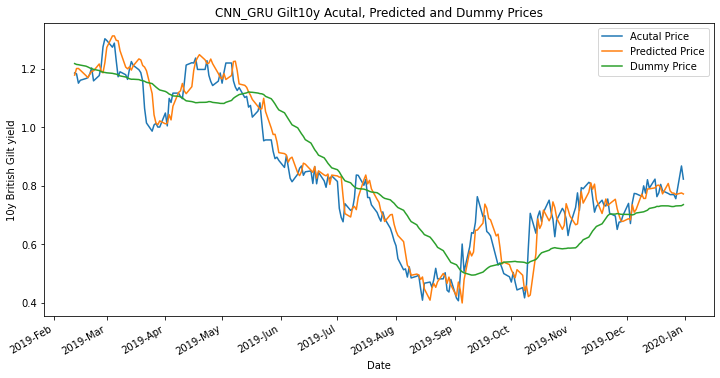

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

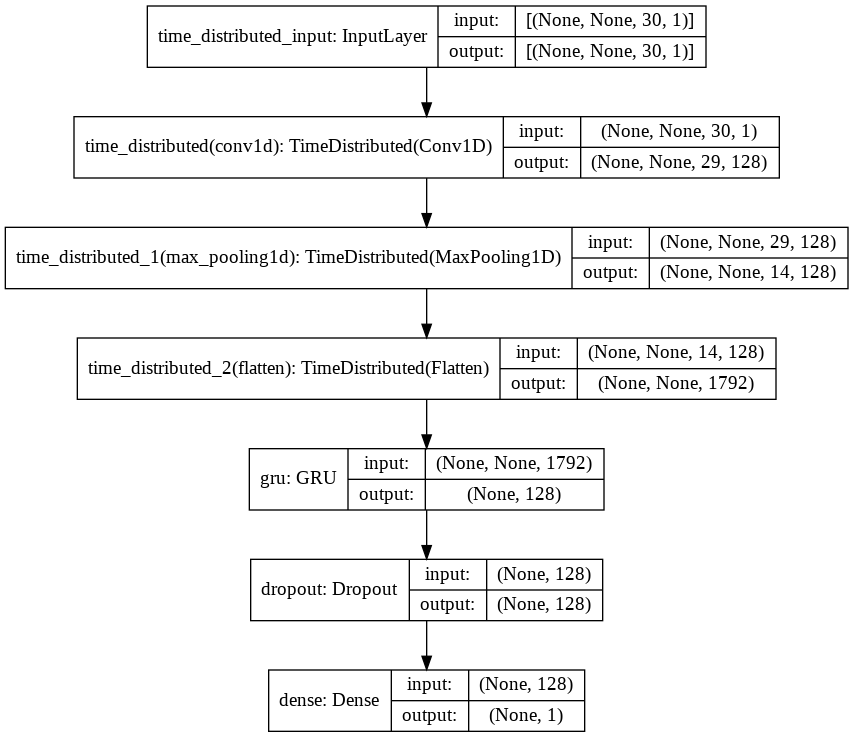

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0038805715648763017
RMSE:  0.062294233801181806
MAE:  0.046030771012614415
Dummy MSE:  0.013891737694778073
Dummy RMSE:  0.11786321603782103
Dummy MAE:  0.09977998323101281


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Gilt10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Gilt10y/assets
